# Milestone 4: Reinforcement Learning Trading Agent

This notebook demonstrates the RL-based trading system with regime-conditioned state space.

**Key components:**
1. Gymnasium-compatible trading environment
2. PPO agent with regime features in state
3. Walk-forward validation framework
4. Performance analysis vs. buy & hold baseline

In [1]:
import sys
sys.path.insert(0, '../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 200)
plt.style.use('seaborn-v0_8-whitegrid')

print("Imports complete!")

Imports complete!


## 1. Load and Prepare Data

We'll combine price features, macro indicators, and regime labels into a unified state space.

In [2]:
from data.data_pipeline import DataPipeline
from regime.hmm_detector import HMMRegimeDetector
from regime.rule_based_detector import RuleBasedRegimeDetector

# Initialize pipeline
pipeline = DataPipeline()

# Load aligned data
print("Loading aligned price and macro data...")
df = pipeline.load_aligned_data(
    symbol='SPY',
    start_date='2020-01-01',
    end_date='2024-01-01'
)

print(f"Data shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"\nColumns: {df.columns.tolist()[:10]}...")

Loading aligned price and macro data...
Data shape: (1462, 48)
Date range: 2020-01-01 00:00:00 to 2024-01-01 00:00:00

Columns: ['price_Open', 'price_High', 'price_Low', 'price_Close', 'price_Adj_Close', 'price_Volume', 'price_Dividends', 'price_Stock_Splits', 'price_Capital_Gains', 'price_return_1d']...


In [3]:
# Add regime labels using rule-based detector
print("\nDetecting market regimes...")

# Prepare macro data for regime detection
macro_cols = ['macro_VIXCLS', 'macro_T10Y2Y', 'macro_BAA10Y', 'macro_UNRATE']
available_macro = [c for c in macro_cols if c in df.columns]

if len(available_macro) >= 2:
    # Rename for detector
    macro_df = df[available_macro].copy()
    macro_df.columns = [c.replace('macro_', '') for c in macro_df.columns]
    
    # Use rule-based detector (more interpretable)
    detector = RuleBasedRegimeDetector()
    df['regime'] = detector.predict(macro_df)
    
    # Convert to numeric for one-hot encoding
    regime_map = {'Expansion': 0, 'Contraction': 1, 'Crisis': 2}
    df['regime_numeric'] = df['regime'].map(regime_map)
    
    print(f"\nRegime distribution:")
    print(df['regime'].value_counts())
else:
    print("Insufficient macro columns for regime detection")
    df['regime'] = 'Unknown'
    df['regime_numeric'] = 0


Detecting market regimes...

Regime distribution:
regime
Contraction    862
Expansion      487
Crisis         113
Name: count, dtype: int64


In [4]:
# Select features for RL state space
# Include price features, macro features, but not the target

# Price-based features (using actual column names from pipeline)
price_features = [
    'price_return_1d', 'price_return_5d', 'price_return_21d',
    'price_volatility_21d', 'price_volatility_63d',
    'price_rsi_14', 'price_close_to_sma50', 'price_close_to_sma200'
]

# Macro features
macro_features = [
    'macro_VIXCLS', 'macro_T10Y2Y', 'macro_VIX_percentile'
]

# Filter to available columns
all_features = price_features + macro_features
feature_columns = [c for c in all_features if c in df.columns]

print(f"Selected {len(feature_columns)} features for state space:")
for f in feature_columns:
    print(f"  - {f}")

# Drop rows with NaN in features
df_clean = df.dropna(subset=feature_columns + ['regime_numeric', 'price_Close'])
print(f"\nClean data shape: {df_clean.shape}")

Selected 11 features for state space:
  - price_return_1d
  - price_return_5d
  - price_return_21d
  - price_volatility_21d
  - price_volatility_63d
  - price_rsi_14
  - price_close_to_sma50
  - price_close_to_sma200
  - macro_VIXCLS
  - macro_T10Y2Y
  - macro_VIX_percentile

Clean data shape: (807, 50)


## 2. Trading Environment Overview

Our custom `TradingEnv` is compatible with Gymnasium and Stable-Baselines3.

In [5]:
from rl.trading_env import TradingEnv

# Create environment
env = TradingEnv(
    df=df_clean,
    feature_columns=feature_columns,
    price_column='price_Close',
    regime_column='regime_numeric',
    n_regimes=3,
    initial_balance=100000.0,
    transaction_cost=0.001,  # 0.1% per trade
)

print("Environment Configuration:")
print(f"  Action space: {env.action_space} (0=Sell, 1=Hold, 2=Buy)")
print(f"  Observation space: {env.observation_space.shape}")
print(f"  State dimension breakdown:")
print(f"    - Features: {len(feature_columns)}")
print(f"    - Regime one-hot: 3")
print(f"    - Portfolio state: 2 (position, unrealized P&L)")
print(f"  Initial balance: ${env.initial_balance:,.0f}")
print(f"  Transaction cost: {env.transaction_cost*100}%")

Environment Configuration:
  Action space: Discrete(3) (0=Sell, 1=Hold, 2=Buy)
  Observation space: (16,)
  State dimension breakdown:
    - Features: 11
    - Regime one-hot: 3
    - Portfolio state: 2 (position, unrealized P&L)
  Initial balance: $100,000
  Transaction cost: 0.1%


In [6]:
# Test environment with random actions
print("\nTesting environment with random actions...")

obs, info = env.reset()
print(f"Initial observation shape: {obs.shape}")
print(f"Initial info: {info}")

# Run a few steps
total_reward = 0
for i in range(10):
    action = env.action_space.sample()
    action_name = ['Sell', 'Hold', 'Buy'][action]
    obs, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    
    if i < 3:  # Show first 3 steps
        print(f"\nStep {i+1}: Action={action_name}")
        print(f"  Reward: {reward:.4f}")
        print(f"  Position: {info['position']:.2f}")
        print(f"  Portfolio: ${info['portfolio_value']:,.2f}")

print(f"\n...")
print(f"\nAfter 10 random steps:")
print(f"  Total reward: {total_reward:.4f}")
print(f"  Final portfolio: ${info['portfolio_value']:,.2f}")


Testing environment with random actions...
Initial observation shape: (16,)
Initial info: {'step': 1, 'date': '2020-10-16 00:00:00', 'price': np.float64(347.2900085449219), 'position': 0.0, 'portfolio_value': 100000.0, 'cash': 100000.0, 'shares_held': 0.0, 'num_trades': 0, 'regime': np.int64(1)}

Step 1: Action=Buy
  Reward: -0.0184
  Position: 1.00
  Portfolio: $98,329.66

Step 2: Action=Hold
  Reward: -0.0024
  Position: 1.00
  Portfolio: $98,724.14

Step 3: Action=Hold
  Reward: -0.0077
  Position: 1.00
  Portfolio: $98,536.98

...

After 10 random steps:
  Total reward: -0.1117
  Final portfolio: $95,848.76


## 3. Train PPO Agent

We use PPO (Proximal Policy Optimization) for training - it's the most stable algorithm for continuous observation spaces.

In [7]:
from rl.ppo_trader import PPOTrader

# Split data: 70% train, 30% test
train_size = int(len(df_clean) * 0.7)
train_df = df_clean.iloc[:train_size].copy()
test_df = df_clean.iloc[train_size:].copy()

print(f"Train period: {train_df.index.min().date()} to {train_df.index.max().date()} ({len(train_df)} days)")
print(f"Test period:  {test_df.index.min().date()} to {test_df.index.max().date()} ({len(test_df)} days)")

Train period: 2020-10-15 to 2023-01-11 (564 days)
Test period:  2023-01-12 to 2023-12-29 (243 days)


In [8]:
# Create and train PPO trader
print("\nInitializing PPO Trader...")

trader = PPOTrader(
    df=train_df,
    feature_columns=feature_columns,
    regime_column='regime_numeric',
    n_regimes=3,
    price_column='price_Close',
    initial_balance=100000.0,
    transaction_cost=0.001,
    seed=42,
    device='cpu',  # Use CPU for stability
    verbose=1
)

print(f"\nPPO Hyperparameters:")
for key, value in trader.ppo_params.items():
    print(f"  {key}: {value}")


Initializing PPO Trader...
Using cpu device



PPO Hyperparameters:
  learning_rate: 0.0003
  n_steps: 2048
  batch_size: 64
  n_epochs: 10
  gamma: 0.99
  gae_lambda: 0.95
  clip_range: 0.2
  ent_coef: 0.01
  vf_coef: 0.5
  max_grad_norm: 0.5


In [9]:
# Train the agent
print("\n" + "="*60)
print("TRAINING PPO AGENT")
print("="*60)

# Note: For demonstration, we use fewer timesteps. Production would use 500k+
TIMESTEPS = 50000  # Reduced for notebook execution speed

train_stats = trader.train(
    total_timesteps=TIMESTEPS,
    progress_bar=False  # Disabled for batch execution
)

print(f"\nTraining complete!")
print(f"  Total timesteps: {train_stats['total_timesteps']}")
print(f"  Episodes completed: {train_stats['episodes']}")


TRAINING PPO AGENT
Training PPO for 50000 timesteps...


Episode 10: Mean Reward (last 10) = -16.56


Episode 20: Mean Reward (last 10) = -18.09


Episode 30: Mean Reward (last 10) = -14.57


Episode 40: Mean Reward (last 10) = -13.60


Episode 50: Mean Reward (last 10) = -11.84


Episode 60: Mean Reward (last 10) = -15.22


Episode 70: Mean Reward (last 10) = -14.74


Episode 80: Mean Reward (last 10) = -12.71


Episode 90: Mean Reward (last 10) = -12.67



Training complete!
  Total timesteps: 50000
  Episodes completed: 91


## 4. Evaluate on Test Data

In [10]:
# Evaluate on training data (in-sample)
print("Evaluating on TRAINING data (in-sample)...")
train_metrics = trader.evaluate(train_df, deterministic=True)

print(f"\nIn-Sample Performance:")
print(f"  Total Return: {train_metrics['total_return']*100:+.2f}%")
print(f"  Sharpe Ratio: {train_metrics['sharpe_ratio']:.3f}")
print(f"  Max Drawdown: {train_metrics['max_drawdown']*100:.2f}%")
print(f"  Num Trades: {train_metrics['num_trades']:.0f}")

Evaluating on TRAINING data (in-sample)...



In-Sample Performance:
  Total Return: +17.14%
  Sharpe Ratio: 0.464
  Max Drawdown: 18.80%
  Num Trades: 14


In [11]:
# Evaluate on test data (out-of-sample)
print("Evaluating on TEST data (out-of-sample)...")
test_metrics = trader.evaluate(test_df, deterministic=True)

print(f"\nOut-of-Sample Performance:")
print(f"  Total Return: {test_metrics['total_return']*100:+.2f}%")
print(f"  Sharpe Ratio: {test_metrics['sharpe_ratio']:.3f}")
print(f"  Max Drawdown: {test_metrics['max_drawdown']*100:.2f}%")
print(f"  Num Trades: {test_metrics['num_trades']:.0f}")

Evaluating on TEST data (out-of-sample)...

Out-of-Sample Performance:
  Total Return: -12.23%
  Sharpe Ratio: -0.895
  Max Drawdown: 17.62%
  Num Trades: 3


In [12]:
# Calculate Buy & Hold baseline for comparison
train_bh_return = (train_df['price_Close'].iloc[-1] / train_df['price_Close'].iloc[0]) - 1
test_bh_return = (test_df['price_Close'].iloc[-1] / test_df['price_Close'].iloc[0]) - 1

print("\n" + "="*60)
print("STRATEGY vs BUY & HOLD COMPARISON")
print("="*60)
print(f"\n{'Metric':<25} {'Strategy':>15} {'Buy & Hold':>15}")
print("-"*55)
print(f"{'Train Return':<25} {train_metrics['total_return']*100:>+14.2f}% {train_bh_return*100:>+14.2f}%")
print(f"{'Test Return':<25} {test_metrics['total_return']*100:>+14.2f}% {test_bh_return*100:>+14.2f}%")
print(f"{'Test Sharpe':<25} {test_metrics['sharpe_ratio']:>15.3f} {'N/A':>15}")
print(f"{'Test Max Drawdown':<25} {test_metrics['max_drawdown']*100:>14.2f}% {'N/A':>15}")


STRATEGY vs BUY & HOLD COMPARISON

Metric                           Strategy      Buy & Hold
-------------------------------------------------------
Train Return                      +17.14%         +13.82%
Test Return                       -12.23%         +19.74%
Test Sharpe                        -0.895             N/A
Test Max Drawdown                  17.62%             N/A


## 5. Visualize Performance

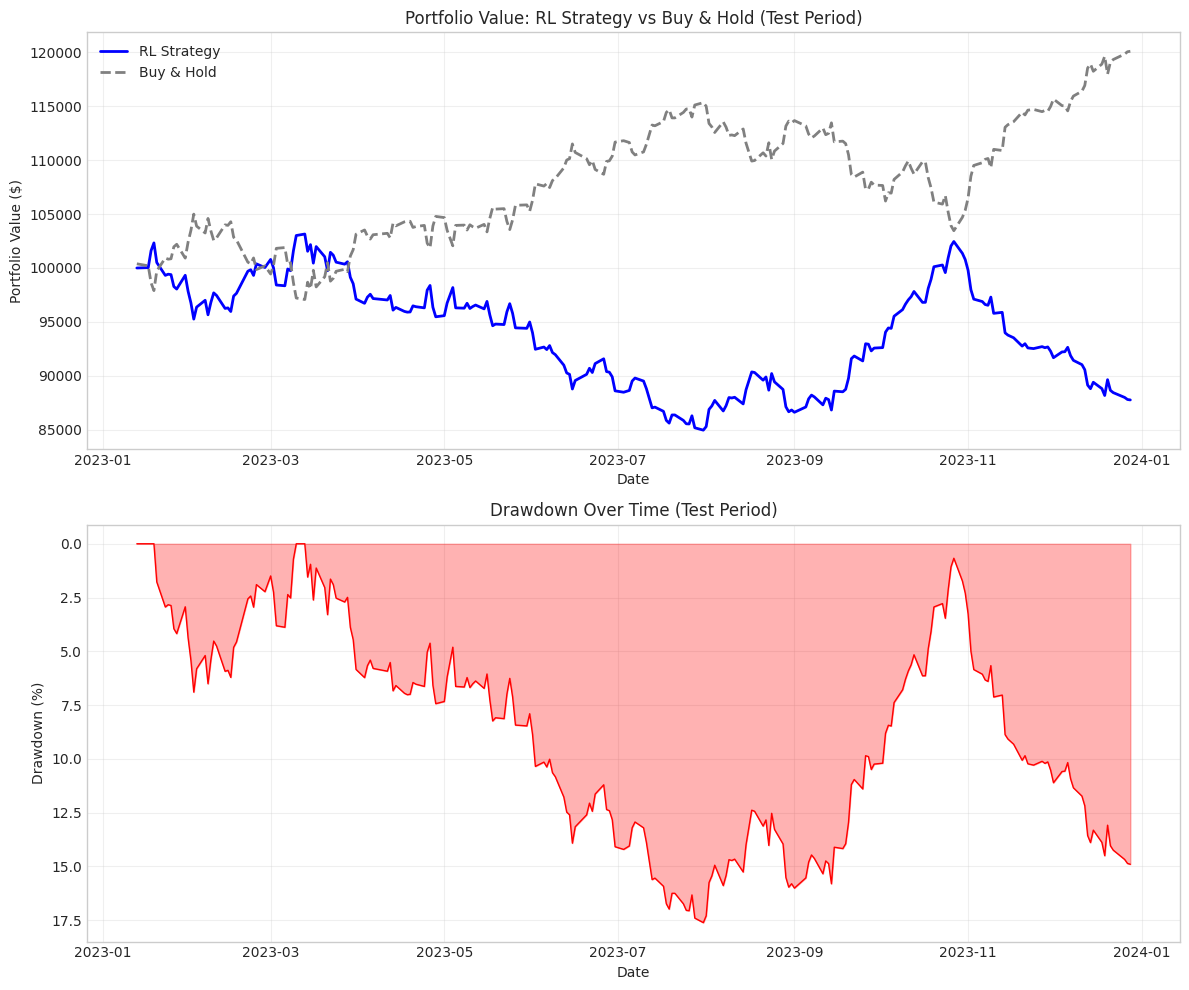

In [13]:
# Get portfolio history from test evaluation
portfolio_history = test_metrics.get('portfolio_history')

if portfolio_history is not None and len(portfolio_history) > 0:
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot 1: Portfolio value vs Buy & Hold
    ax = axes[0]
    
    # Strategy portfolio
    ax.plot(portfolio_history.index, portfolio_history['portfolio_value'], 
            label='RL Strategy', linewidth=2, color='blue')
    
    # Buy & Hold portfolio
    initial_value = 100000
    bh_values = initial_value * (test_df['price_Close'] / test_df['price_Close'].iloc[0])
    # Align dates
    common_dates = portfolio_history.index.intersection(bh_values.index)
    if len(common_dates) > 0:
        ax.plot(common_dates, bh_values.loc[common_dates], 
                label='Buy & Hold', linewidth=2, color='gray', linestyle='--')
    
    ax.set_title('Portfolio Value: RL Strategy vs Buy & Hold (Test Period)')
    ax.set_xlabel('Date')
    ax.set_ylabel('Portfolio Value ($)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Drawdown
    ax = axes[1]
    portfolio_values = portfolio_history['portfolio_value'].values
    cummax = np.maximum.accumulate(portfolio_values)
    drawdown = (cummax - portfolio_values) / cummax * 100
    
    ax.fill_between(portfolio_history.index, 0, drawdown, color='red', alpha=0.3)
    ax.plot(portfolio_history.index, drawdown, color='red', linewidth=1)
    ax.set_title('Drawdown Over Time (Test Period)')
    ax.set_xlabel('Date')
    ax.set_ylabel('Drawdown (%)')
    ax.invert_yaxis()  # Drawdown is typically shown inverted
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No portfolio history available for plotting")

## 6. Walk-Forward Validation

Walk-forward validation is critical for time-series models. It simulates realistic model retraining.

In [14]:
from rl.walk_forward import WalkForwardValidator

print("Setting up Walk-Forward Validation...")
print("(This trains multiple models on different time windows)")

validator = WalkForwardValidator(
    df=df_clean,
    feature_columns=feature_columns,
    regime_column='regime_numeric',
    n_regimes=3,
    price_column='price_Close',
    n_windows=3,  # 3 validation windows
    train_pct=0.7,
    min_train_days=200,
    min_test_days=50,
    verbose=1
)

print(f"\nGenerated {len(validator.windows)} walk-forward windows:")
for w in validator.windows:
    print(f"  Window {w.window_id + 1}: Train {w.train_start.date()} to {w.train_end.date()}, "
          f"Test {w.test_start.date()} to {w.test_end.date()}")

Setting up Walk-Forward Validation...
(This trains multiple models on different time windows)

Generated 2 walk-forward windows:
  Window 1: Train 2020-10-15 to 2021-11-26, Test 2021-11-29 to 2022-05-20
  Window 2: Train 2021-11-09 to 2022-12-21, Test 2022-12-22 to 2023-06-16


In [15]:
# Run walk-forward validation
# Note: Using reduced timesteps for notebook demo
print("\n" + "="*60)
print("RUNNING WALK-FORWARD VALIDATION")
print("="*60)

wf_results = validator.run(
    total_timesteps=25000,  # Reduced for demo
    seeds=[42],  # Single seed for speed
    save_models=False
)


RUNNING WALK-FORWARD VALIDATION

Window 1/2
Train: 2020-10-15 to 2021-11-26 (282 days)
Test:  2021-11-29 to 2022-05-20 (121 days)


Output()

Output()

  Seed 42: Train Return=35.0%, Test Return=-14.7%

Window 2/2
Train: 2021-11-09 to 2022-12-21 (282 days)
Test:  2022-12-22 to 2023-06-16 (121 days)


  Seed 42: Train Return=-15.7%, Test Return=14.5%


In [16]:
# Print walk-forward summary
validator.print_summary(wf_results)


WALK-FORWARD VALIDATION SUMMARY

Windows: 2, Seeds per window: 1

Metric                         Strategy        Buy & Hold     
------------------------------------------------------------
Mean Return                    -0.06%         -0.35%
Std Return                     14.60%          15.78%
Mean Sharpe                    0.779
Mean Max Drawdown              10.55%
Win Rate (windows > 0)         50.0%

Overfitting Check             
  Train Mean Return            +9.67%
  Test Mean Return             -0.06%
  Overfit Ratio                -161.65x



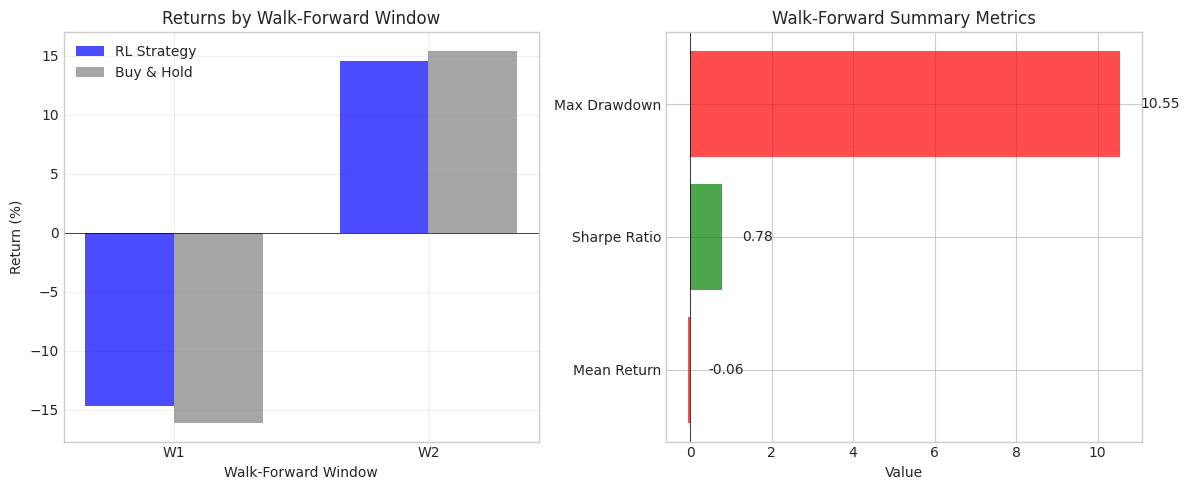

In [17]:
# Visualize walk-forward results
summary = wf_results['summary']
baseline = wf_results['baseline']

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Returns by window
ax = axes[0]
windows = range(1, len(summary['per_window_returns']) + 1)
width = 0.35

strategy_returns = [r * 100 for r in summary['per_window_returns']]
baseline_returns = [r * 100 for r in baseline['per_window_returns']]

x = np.arange(len(windows))
bars1 = ax.bar(x - width/2, strategy_returns, width, label='RL Strategy', color='blue', alpha=0.7)
bars2 = ax.bar(x + width/2, baseline_returns, width, label='Buy & Hold', color='gray', alpha=0.7)

ax.axhline(0, color='black', linewidth=0.5)
ax.set_xlabel('Walk-Forward Window')
ax.set_ylabel('Return (%)')
ax.set_title('Returns by Walk-Forward Window')
ax.set_xticks(x)
ax.set_xticklabels([f'W{i}' for i in windows])
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Summary metrics
ax = axes[1]
metrics = ['Mean Return', 'Sharpe Ratio', 'Max Drawdown']
strategy_vals = [
    summary['test_mean_return'] * 100,
    summary['test_mean_sharpe'],
    summary['test_mean_drawdown'] * 100
]

colors = ['green' if v > 0 else 'red' for v in strategy_vals]
colors[2] = 'red'  # Drawdown is always "bad"

bars = ax.barh(metrics, strategy_vals, color=colors, alpha=0.7)
ax.axvline(0, color='black', linewidth=0.5)
ax.set_xlabel('Value')
ax.set_title('Walk-Forward Summary Metrics')

# Add value labels
for bar, val in zip(bars, strategy_vals):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
            f'{val:.2f}', va='center')

plt.tight_layout()
plt.show()

## 7. Regime-Conditional Analysis

Does the agent perform differently in different regimes?

In [18]:
# Analyze agent behavior by regime
# Re-run evaluation to get detailed action history

eval_env = TradingEnv(
    df=test_df,
    feature_columns=feature_columns,
    price_column='price_Close',
    regime_column='regime_numeric',
    n_regimes=3,
    initial_balance=100000.0,
    transaction_cost=0.001
)

obs, info = eval_env.reset()
actions_by_regime = {'Expansion': [], 'Contraction': [], 'Crisis': []}
regime_names = {0: 'Expansion', 1: 'Contraction', 2: 'Crisis'}

done = False
step = 0
while not done:
    action, _ = trader.predict(obs, deterministic=True)
    
    # Get current regime
    current_regime = test_df.iloc[eval_env.current_step]['regime_numeric']
    regime_name = regime_names.get(current_regime, 'Unknown')
    
    if regime_name in actions_by_regime:
        actions_by_regime[regime_name].append(action)
    
    obs, reward, terminated, truncated, info = eval_env.step(action)
    done = terminated or truncated
    step += 1

# Analyze action distribution by regime
print("\nAgent Action Distribution by Regime:")
print("="*50)
action_names = {0: 'Sell', 1: 'Hold', 2: 'Buy'}

for regime, actions in actions_by_regime.items():
    if len(actions) > 0:
        action_counts = pd.Series(actions).value_counts(normalize=True)
        print(f"\n{regime} ({len(actions)} steps):")
        for action_id in [0, 1, 2]:
            pct = action_counts.get(action_id, 0) * 100
            print(f"  {action_names[action_id]}: {pct:.1f}%")


Agent Action Distribution by Regime:

Contraction (241 steps):
  Sell: 54.4%
  Hold: 45.2%
  Buy: 0.4%


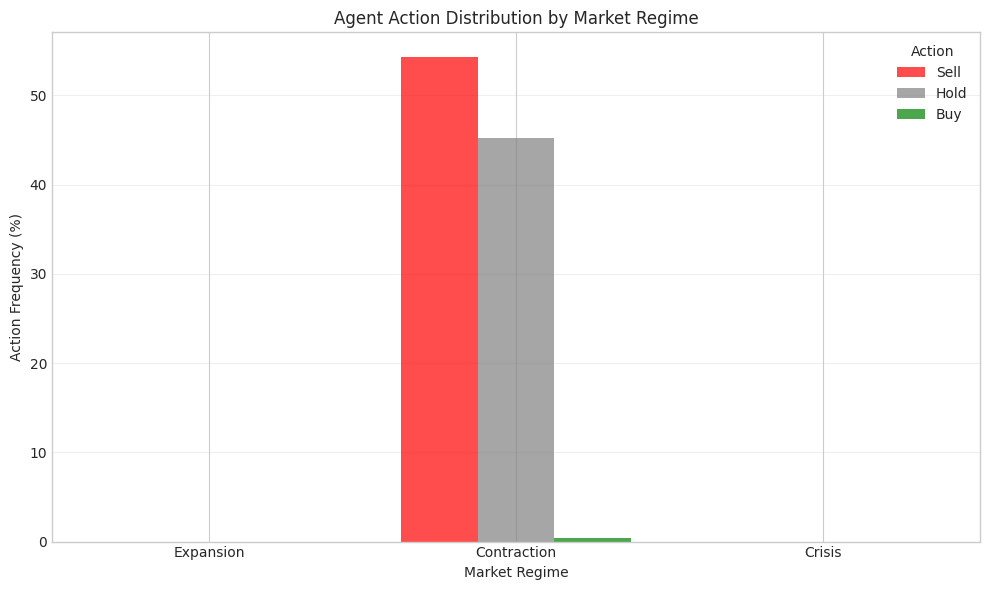

In [19]:
# Visualize action distribution by regime
fig, ax = plt.subplots(figsize=(10, 6))

regime_order = ['Expansion', 'Contraction', 'Crisis']
action_order = ['Sell', 'Hold', 'Buy']
colors = ['red', 'gray', 'green']

# Build data for stacked bar chart
data = {}
for regime in regime_order:
    actions = actions_by_regime.get(regime, [])
    if len(actions) > 0:
        counts = pd.Series(actions).value_counts(normalize=True)
        data[regime] = [counts.get(i, 0) * 100 for i in range(3)]
    else:
        data[regime] = [0, 0, 0]

x = np.arange(len(regime_order))
width = 0.25

for i, (action_name, color) in enumerate(zip(action_order, colors)):
    values = [data[regime][i] for regime in regime_order]
    ax.bar(x + i*width, values, width, label=action_name, color=color, alpha=0.7)

ax.set_xlabel('Market Regime')
ax.set_ylabel('Action Frequency (%)')
ax.set_title('Agent Action Distribution by Market Regime')
ax.set_xticks(x + width)
ax.set_xticklabels(regime_order)
ax.legend(title='Action')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 8. Key Findings Summary

In [20]:
print("="*70)
print("MILESTONE 4: RL TRADING AGENT - KEY FINDINGS")
print("="*70)

print(f"\n1. ENVIRONMENT:")
print(f"   State dimension: {env.observation_space.shape[0]} features")
print(f"   Action space: 3 discrete actions (Sell, Hold, Buy)")
print(f"   Reward: Differential Sharpe ratio with drawdown penalty")

print(f"\n2. SINGLE TRAIN/TEST SPLIT:")
print(f"   Train Return: {train_metrics['total_return']*100:+.2f}%")
print(f"   Test Return:  {test_metrics['total_return']*100:+.2f}%")
print(f"   Buy & Hold:   {test_bh_return*100:+.2f}%")

print(f"\n3. WALK-FORWARD VALIDATION ({len(validator.windows)} windows):")
print(f"   Mean Test Return: {summary['test_mean_return']*100:+.2f}% (+/- {summary['test_std_return']*100:.2f}%)")
print(f"   Mean Sharpe Ratio: {summary['test_mean_sharpe']:.3f}")
print(f"   Win Rate (windows > 0): {summary['test_win_rate']*100:.1f}%")

if summary['p_value'] is not None:
    print(f"   Statistical Significance: p={summary['p_value']:.4f}")

print(f"\n4. REGIME-CONDITIONAL BEHAVIOR:")
for regime, actions in actions_by_regime.items():
    if len(actions) > 0:
        buy_pct = sum(1 for a in actions if a == 2) / len(actions) * 100
        sell_pct = sum(1 for a in actions if a == 0) / len(actions) * 100
        print(f"   {regime}: Buy={buy_pct:.1f}%, Sell={sell_pct:.1f}%")

print("\n" + "="*70)

MILESTONE 4: RL TRADING AGENT - KEY FINDINGS

1. ENVIRONMENT:
   State dimension: 16 features
   Action space: 3 discrete actions (Sell, Hold, Buy)
   Reward: Differential Sharpe ratio with drawdown penalty

2. SINGLE TRAIN/TEST SPLIT:
   Train Return: +17.14%
   Test Return:  -12.23%
   Buy & Hold:   +19.74%

3. WALK-FORWARD VALIDATION (2 windows):
   Mean Test Return: -0.06% (+/- 14.60%)
   Mean Sharpe Ratio: 0.779
   Win Rate (windows > 0): 50.0%

4. REGIME-CONDITIONAL BEHAVIOR:
   Contraction: Buy=0.4%, Sell=54.4%



In [21]:
print("\nNotebook complete!")
print("\nNext steps:")
print("  - Milestone 5: Ablation studies (price-only vs +regime vs +sentiment)")
print("  - Statistical significance testing across configurations")
print("  - Final documentation and results summary")


Notebook complete!

Next steps:
  - Milestone 5: Ablation studies (price-only vs +regime vs +sentiment)
  - Statistical significance testing across configurations
  - Final documentation and results summary
